# Plot paper Figure 4: Example transects for different ASC regimes

This script plots 
- 3 cross-slope transects for each of the 3 ASC regimes (along-slope velocity in shading and isopaycnals as contours),
- a map with the 1000-m isobath colour-coded with the regime classification.

The ASC classification is done in `Calc_ASC_regimes.ipynb`.

Load modules:

In [1]:
# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr

# For gradient calculation
# (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
import xarray.ufuncs as xu

# Load metpy module to obtain cross section
# (Select the conda/analysis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

# For density calculation
from gsw import SA_from_SP, p_from_z, sigma1 

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

Start a cluster with multiple cores:

In [2]:
client = Client() # n_workers=8
client

Client Scheduler: tcp://127.0.0.1:38123 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


Nominate a database from which to load the data and define an experiment:

In [3]:
# Load database
#session = cc.database.create_session('/g/data/ik11/databases/ryf9091.db')
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Load and prepare velocity

In [4]:
# Select data in the southern Southern Ocean
lat_slice  = slice(-80, -59)
# We will use an annual average from one year in the RYF run
#start_time = '2086-01-01'
#end_time   = '2086-12-31'
start_time = '2080-01-01'
end_time   = '2089-12-31'

Bathymetry

In [5]:
# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

ht = cc.querying.getvar(expt, 'ht', session, n=1)
ht = ht.sel(yt_ocean=lat_slice)
ht = ht.load()

Velocity

In [6]:
# Import velocity
# u_daily = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency="1 daily")
# u_daily = u_daily.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.mean('time')
# v_daily = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency="1 daily")
# v_daily = v_daily.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.mean('time')

u_monthly = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency="1 monthly")
u_monthly = u_monthly.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.mean('time')
v_monthly = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency="1 monthly")
v_monthly = v_monthly.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.mean('time')
u_annual  = u_monthly.mean('time')
v_annual  = v_monthly.mean('time')

Density

In [7]:
# Conservative temperature
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, frequency="1 monthly") - 273.15
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean('time')
# Practical salinity
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, frequency="1 monthly")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean('time')

In [8]:
# Pressure
pressure = p_from_z(-salt.st_ocean, salt.yt_ocean)
# Absolute salinity
salt_abs = SA_from_SP(salt, pressure, salt.xt_ocean, salt.yt_ocean)
# Potential density, referenced to 1000 dbar
sigma_1   = sigma1(salt_abs, temp)
sigma_1 = sigma_1.rename('sigma1')

In [81]:
# Try sigma_0:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency="1 monthly") #- 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean('time')
sigma_1 = pot_rho_0

Grid info

In [12]:
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

# Information on grid (to calculate along-slope component later in the script)
ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')
# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
slope = np.sqrt(dhu_dx**2 + dhu_dy**2)

Parsing

In [13]:
# Create dataset
ds = xr.Dataset({"u_annual": u_annual, "v_annual": v_annual, "hu": hu, \
                "slope": slope, "dhu_dx": dhu_dx, "dhu_dy": dhu_dy})
#ds = xr.Dataset({"u_annual": u_annual, "v_annual": v_annual, "lat": u_annual.yu_ocean, "lon": u_annual.xu_ocean, "hu": hu, \
#                "slope": slope, "dhu_dx": dhu_dx, "dhu_dy": dhu_dy})
# Rename coordinate names
ds = ds.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Below not needed as we only need the parsed data for the region of the Antarctic Peninsula, longitude range is ok.
# Convert longitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
#ds['x'] = ds['x']+100
#ds['x'].attrs = u_annual['xu_ocean'].attrs
# MetPy parsing
data_parsed = ds.metpy.parse_cf(coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [14]:
# Density
ds_sigma1 = xr.Dataset({"sigma1": sigma_1, "ht": ht})
# Rename coordinate names
ds_sigma1 = ds_sigma1.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
# MetPy parsing
sigma1_parsed = ds_sigma1.metpy.parse_cf(coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


### Map of the Antarctic margin 
...with the ASC regimes plotted on the 1 km isobath and locations of transects.

1 km isobath information

In [15]:
isobath_depth = 1000
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

ASC regime information

In [16]:
file_path   = '/g/data/x77/wgh581/Post_Process/'
file_name   = 'ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'
ASC_regimes = np.load(file_path + file_name)
ASC_regimes = ASC_regimes['ASC_regimes_annual']

For plotting

In [17]:
ft_size = 20
fig_path = '/g/data/x77/wgh581/Figures/'

In [18]:
# Costum colormap
import matplotlib
colorsList_no4 = [('limegreen'),('blueviolet'),('tomato'),('c')]
CustomCmap_no4 = matplotlib.colors.ListedColormap(colorsList_no4)
colorsList_no3 = [('mediumseagreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

In [19]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

Information for cross-slope transects

In [20]:
regime = [0, 0, 0, 1, 1, 1, 2, 2, 2]
count_regime = [1, 2, 3, 1, 2, 3, 1, 2, 3]

In [21]:
transect_lons_sel = [[-260, -260], [-150, -150], [-15, -15], [-185, -185], [-58, -52], [65, 65], [-115, -115], [-74, -68.5], [-56.5, -59]]
transect_lats_sel = [[-65.25, -62.8], [-76.45, -74.5], [-72.1, -70.5], [-74, -71], [-67, -67], [-67.5, -65.5], [-74, -70.5], [-65, -66.5], [-62, -60]]

Plot map

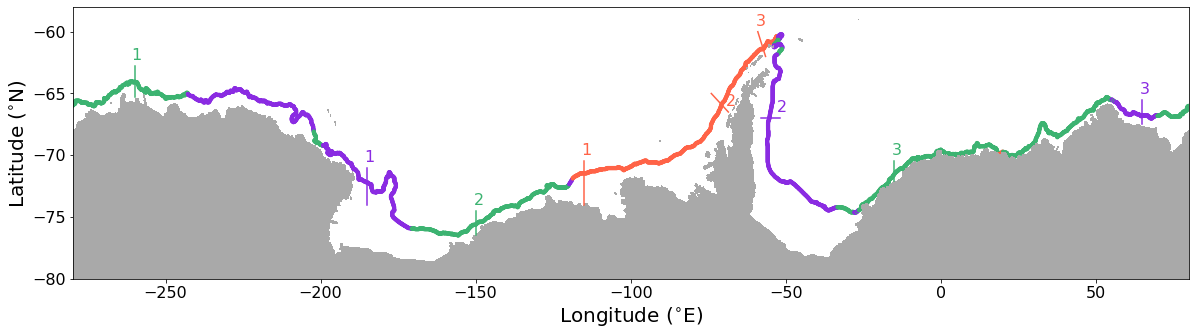

In [19]:
fig = plt.figure(figsize=(20, 5))

sc = plt.scatter(lon_along_contour, lat_along_contour, c=ASC_regimes, cmap=CustomCmap_no3, s=10)

for ii in range(len(transect_lons_sel)):
    if regime[ii] == 0:
        clr_transect = 'mediumseagreen'
    elif regime[ii] == 1:
        clr_transect = 'blueviolet'
    elif regime[ii] == 2:
        clr_transect = 'tomato'
    plt.plot(transect_lons_sel[ii], transect_lats_sel[ii], color=clr_transect)
    plt.text(transect_lons_sel[ii][1]-1, transect_lats_sel[ii][1]+0.5, '$\mathsf{'+str(count_regime[ii])+'}$', fontsize=ft_size-4, color=clr_transect)

plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -58)  #(-82.5, -58)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
plt.xticks(fontsize=ft_size-4)
plt.yticks(np.arange(-80, -59, 5), fontsize=ft_size-4);

### Cross-slope transects

Functions to calculate along-slope velocity transects

In [22]:
def gcdist(lat1, lat2, lon1, lon2):

    # Radius of the Earth in km
    r = 6371
    # Difference between points (lon/lat)
    dlon = lon2-lon1
    dlat = lat2-lat1
    # Calculate distance in km
    gcdist = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([lat1,lat2]))))**2))

    return gcdist

In [23]:
def get_transect_annual(lon_values, lat_values, ii):
    # Longitude values
    lon_min = lon_values[ii][0]
    lon_max = lon_values[ii][1]
    # Latitude values
    lat_min = lat_values[ii][0]
    lat_max = lat_values[ii][1]

    if lon_min == lon_max:
        # Meridional transects
        dhu_dy_tmp   = dhu_dy.sel(xu_ocean=lon_min, method='nearest').sel(yu_ocean=slice(lat_min, lat_max))
        dhu_dx_tmp   = dhu_dx.sel(xu_ocean=lon_min, method='nearest').sel(yu_ocean=slice(lat_min, lat_max))
        slope_tmp    = slope.sel(xu_ocean=lon_min, method='nearest').sel(yu_ocean=slice(lat_min, lat_max))
        u_tmp        = u_annual.sel(xu_ocean=lon_min, method='nearest').sel(yu_ocean=slice(lat_min, lat_max))
        v_tmp        = v_annual.sel(xu_ocean=lon_min, method='nearest').sel(yu_ocean=slice(lat_min, lat_max))
        u_along_tmp  = u_tmp*dhu_dy_tmp/slope_tmp - v_tmp*dhu_dx_tmp/slope_tmp
        hu_tmp       = hu.sel(xu_ocean=lon_min, method='nearest').sel(yu_ocean=slice(lat_min, lat_max))
        distance_tmp = np.zeros_like(hu_tmp)
        for dd in range(len(distance_tmp)-1):
            lat1 = hu_tmp.yu_ocean[dd]
            lat2 = hu_tmp.yu_ocean[dd+1]
            lon1 = hu_tmp.xu_ocean
            lon2 = hu_tmp.xu_ocean
            distance_tmp[dd+1] = gcdist(lat1, lat2, lon1, lon2)
        distance_tmp = distance_tmp.cumsum()
    elif lat_min == lat_max:
        # Zonal transects
        dhu_dy_tmp   = dhu_dy.sel(yu_ocean=lat_min, method='nearest').sel(xu_ocean=slice(lon_min, lon_max))
        dhu_dx_tmp   = dhu_dx.sel(yu_ocean=lat_min, method='nearest').sel(xu_ocean=slice(lon_min, lon_max))
        slope_tmp    = slope.sel(yu_ocean=lat_min, method='nearest').sel(xu_ocean=slice(lon_min, lon_max))
        u_tmp        = u_annual.sel(yu_ocean=lat_min, method='nearest').sel(xu_ocean=slice(lon_min, lon_max))
        v_tmp        = v_annual.sel(yu_ocean=lat_min, method='nearest').sel(xu_ocean=slice(lon_min, lon_max))
        u_along_tmp  = u_tmp*dhu_dy_tmp/slope_tmp - v_tmp*dhu_dx_tmp/slope_tmp
        hu_tmp       = hu.sel(yu_ocean=lat_min, method='nearest').sel(xu_ocean=slice(lon_min, lon_max))
        distance_tmp = np.zeros_like(hu_tmp)
        for dd in range(len(distance_tmp)-1):
            lat1 = hu_tmp.yu_ocean
            lat2 = hu_tmp.yu_ocean
            lon1 = hu_tmp.xu_ocean[dd]
            lon2 = hu_tmp.xu_ocean[dd+1]
            distance_tmp[dd+1] = gcdist(lat1, lat2, lon1, lon2)
        distance_tmp = distance_tmp.cumsum()
    else:
        # Sloped transects
        step_no = 50
        # Interpolate gridded data onto the section
        dhu_dy_tmp   = cross_section(data_parsed.dhu_dy, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        dhu_dx_tmp   = cross_section(data_parsed.dhu_dx, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        slope_tmp    = cross_section(data_parsed.slope, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        u_tmp        = cross_section(data_parsed.u_annual, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        v_tmp        = cross_section(data_parsed.v_annual, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        u_along_tmp  = u_tmp*dhu_dy_tmp/slope_tmp - v_tmp*dhu_dx_tmp/slope_tmp
        hu_tmp       = cross_section(data_parsed.hu, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        distance_tmp = np.zeros_like(hu_tmp)
        for dd in range(len(distance_tmp)-1):
            lat1 = hu_tmp.y[dd]
            lat2 = hu_tmp.y[dd+1]
            lon1 = hu_tmp.x[dd]
            lon2 = hu_tmp.x[dd+1]
            distance_tmp[dd+1] = gcdist(lat1, lat2, lon1, lon2)
        distance_tmp = distance_tmp.cumsum()
    
    return u_along_tmp, hu_tmp, distance_tmp

In [24]:
def get_transect_annual_sigma1(lon_values, lat_values, ii):
    # Longitude values
    lon_min = lon_values[ii][0]
    lon_max = lon_values[ii][1]
    # Latitude values
    lat_min = lat_values[ii][0]
    lat_max = lat_values[ii][1]

    if lon_min == lon_max:
        # Meridional transects
        sigma1_tmp   = sigma_1.sel(xt_ocean=lon_min, method='nearest').sel(yt_ocean=slice(lat_min, lat_max))
        ht_tmp       = ht.sel(xt_ocean=lon_min, method='nearest').sel(yt_ocean=slice(lat_min, lat_max))
        distance_tmp = np.zeros_like(ht_tmp)
        for dd in range(len(distance_tmp)-1):
            lat1 = ht_tmp.yt_ocean[dd]
            lat2 = ht_tmp.yt_ocean[dd+1]
            lon1 = ht_tmp.xt_ocean
            lon2 = ht_tmp.xt_ocean
            distance_tmp[dd+1] = gcdist(lat1, lat2, lon1, lon2)
        distance_tmp = distance_tmp.cumsum()
    elif lat_min == lat_max:
        # Zonal transects
        sigma1_tmp   = sigma_1.sel(yt_ocean=lat_min, method='nearest').sel(xt_ocean=slice(lon_min, lon_max))
        ht_tmp       = ht.sel(yt_ocean=lat_min, method='nearest').sel(xt_ocean=slice(lon_min, lon_max))
        distance_tmp = np.zeros_like(ht_tmp)
        for dd in range(len(distance_tmp)-1):
            lat1 = ht_tmp.yt_ocean
            lat2 = ht_tmp.yt_ocean
            lon1 = ht_tmp.xt_ocean[dd]
            lon2 = ht_tmp.xt_ocean[dd+1]
            distance_tmp[dd+1] = gcdist(lat1, lat2, lon1, lon2)
        distance_tmp = distance_tmp.cumsum()
    else:
        # Sloped transects
        step_no = 50
        # Interpolate gridded data onto the section
        sigma1_tmp   = cross_section(sigma1_parsed.sigma1, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        ht_tmp       = cross_section(sigma1_parsed.ht, start=(lat_min, lon_min), end=(lat_max, lon_max), steps=step_no, interp_type='linear')
        distance_tmp = np.zeros_like(ht_tmp)
        for dd in range(len(distance_tmp)-1):
            lat1 = ht_tmp.y[dd]
            lat2 = ht_tmp.y[dd+1]
            lon1 = ht_tmp.x[dd]
            lon2 = ht_tmp.x[dd+1]
            distance_tmp[dd+1] = gcdist(lat1, lat2, lon1, lon2)
        distance_tmp = distance_tmp.cumsum()
    
    return sigma1_tmp, ht_tmp, distance_tmp

### Adjust cross-slope transect lat/lon

Find new start-end points of transects (km 50 centered very roughly around 1 km isobath).

-64.39592049200782
-62.93229800548118
-259.99999999999545


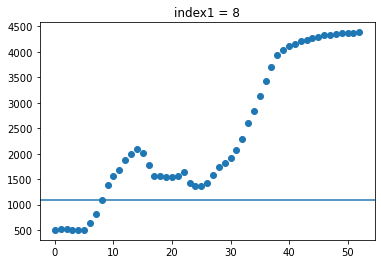

In [193]:
# u_tmp, hu_tmp, distance_tmp = get_transect_annual(transect_lons_sel, transect_lats_sel, 0)

# index1 = np.where((hu_tmp[:]-1100)**2 == np.min((hu_tmp[:]-1100)**2))[0][0] + 0
# fig = plt.figure()
# plt.plot(hu_tmp, 'o')
# plt.axhline(hu_tmp[index1])
# plt.title('index1 = %i'%index1)

# index2 = np.argmin((distance_tmp-(distance_tmp[index1]-50))**2)
# index3 = np.argmin((distance_tmp-(distance_tmp[index1]+125))**2)
# # Meridional transects
# print(u_tmp.yu_ocean[index2].values)
# print(u_tmp.yu_ocean[index3].values)
# print(u_tmp.xu_ocean.values)

# # Zonal transects
# #print(u_tmp.xu_ocean[index2].values)
# #print(u_tmp.xu_ocean[index3].values)
# #print(u_tmp.yu_ocean.values)

# # Sloped transects
# #print(u_tmp.x[index2].values)
# #print(u_tmp.y[index2].values)
# #print(u_tmp.x[index3].values)
# #print(u_tmp.y[index3].values)

In [23]:
# transect_lat_updated = [[-64.439, -62.732], [-76.061, -74.356], [-72.006, -70.4], [-72.64, -71.035], [-67, -67], [-67.233, -65.501], [-71.879, -70.1], [-66.181, -65.194], [-61.757, -60.247]]
# transect_lon_updated = [[-260, -260], [-150, -150], [-15, -15], [-185, -185], [-56.3, -52], [65, 65], [-115, -115], [-69.79, -73.361], [-56.823, -58.71]]

-56.823
-61.758
-58.017
-60.822


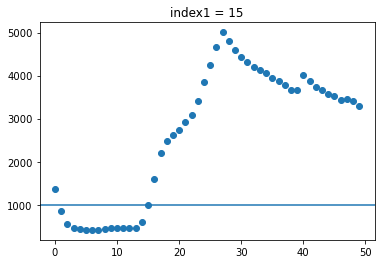

In [55]:
ii = 8
u_tmp, hu_tmp, distance_tmp = get_transect_annual(transect_lons_sel, transect_lats_sel, ii)

if ii not in (5, 6, 7):
    index1 = np.where((hu_tmp[:]-1100)**2 == np.min((hu_tmp[:]-1100)**2))[0][0] + 0
if ii == 5:
    index1 = np.where((hu_tmp[5:]-1100)**2 == np.min((hu_tmp[5:]-1100)**2))[0][0] + 5
if ii == 6:
    index1 = np.where((hu_tmp[20:]-1100)**2 == np.min((hu_tmp[20:]-1100)**2))[0][0] + 20
if ii == 7:
    index1 = np.where((hu_tmp[:]-1100)**2 == np.min((hu_tmp[:]-1100)**2))[0][0] - 1
fig = plt.figure()
plt.plot(hu_tmp, 'o')
plt.axhline(hu_tmp[index1])
plt.title('index1 = %i'%index1)

if ii != 7:
    index2 = np.argmin((distance_tmp-(distance_tmp[index1]-50))**2)
    index3 = np.argmin((distance_tmp-(distance_tmp[index1]+75))**2)
else:
    index2 = np.argmin((distance_tmp-(distance_tmp[index1]+50))**2)
    index3 = np.argmin((distance_tmp-(distance_tmp[index1]-75))**2)

if ii in (0, 1, 2, 3, 5, 6):
    # Meridional transects
    print(np.round(u_tmp.yu_ocean[index2].values,3))
    print(np.round(u_tmp.yu_ocean[index3].values,3))
    print(np.round(u_tmp.xu_ocean.values,3))
elif ii == 4:
    # Zonal transects
    print(np.round(u_tmp.xu_ocean[index2].values,3))
    print(np.round(u_tmp.xu_ocean[index3].values,3))
    print(np.round(u_tmp.yu_ocean.values,3))
elif ii in (7, 8):
    # Sloped transects
    print(np.round(u_tmp.x[index2].values,3))
    print(np.round(u_tmp.y[index2].values,3))
    print(np.round(u_tmp.x[index3].values,3))
    print(np.round(u_tmp.y[index3].values,3))

In [25]:
transect_lat_updated = [[-64.482, -63.384], [-76.061, -74.921], [-72.006, -70.866], [-72.64, -71.499], [-67, -67], [-67.233, -66.093], [-71.879, -70.739], [-66.151, -65.543], [-61.758, -60.822]]
transect_lon_updated = [[-260, -260], [-150, -150], [-15, -15], [-185, -185], [-56.3, -53.5], [65, 65], [-115, -115], [-69.906, -72.164], [-56.823, -58.017]]

Plot transects again on map. Black are the adjusted (centered around 1000-m isobath) transects.

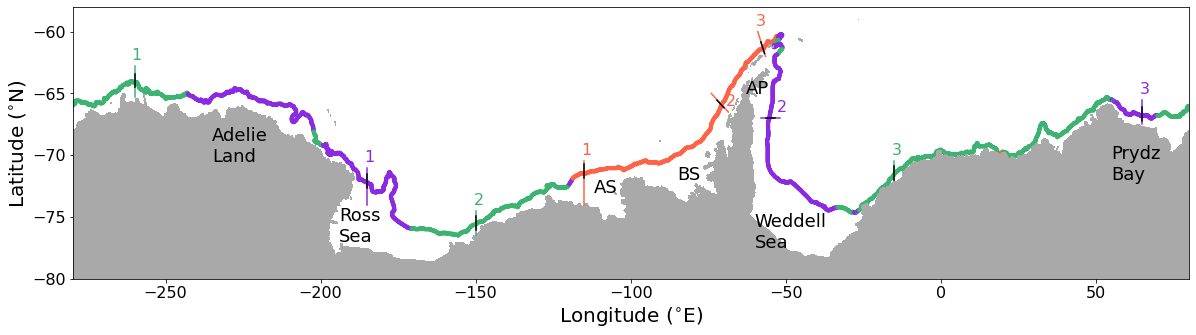

In [25]:
fig = plt.figure(figsize=(20, 5))

sc = plt.scatter(lon_along_contour, lat_along_contour, c=ASC_regimes, cmap=CustomCmap_no3, s=10)

for ii in range(len(transect_lons_sel)):
    if regime[ii] == 0:
        clr_transect = 'mediumseagreen'
    elif regime[ii] == 1:
        clr_transect = 'blueviolet'
    elif regime[ii] == 2:
        clr_transect = 'tomato'
    plt.plot(transect_lons_sel[ii], transect_lats_sel[ii], color=clr_transect)
    plt.plot(transect_lon_updated[ii], transect_lat_updated[ii], color='k')
    plt.text(transect_lons_sel[ii][1]-1, transect_lats_sel[ii][1]+0.5, '$\mathsf{'+str(count_regime[ii])+'}$', fontsize=ft_size-4, color=clr_transect)

plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -58)  #(-82.5, -58)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
plt.xticks(fontsize=ft_size-4)
plt.yticks(np.arange(-80, -59, 5), fontsize=ft_size-4);

# Add text to label regions
plt.text(-235, -70.5, 'Adelie\nLand', fontsize=ft_size-2, color='k')
plt.text(-194, -77.0, 'Ross\nSea', fontsize=ft_size-2, color='k')
plt.text(-112, -73, 'AS', fontsize=ft_size-2, color='k')
plt.text(-85, -72, 'BS', fontsize=ft_size-2, color='k')
plt.text(-63, -65, 'AP', fontsize=ft_size-2, color='k')
plt.text(-60, -77.5, 'Weddell\nSea', fontsize=ft_size-2, color='k')
plt.text(55, -72, 'Prydz\nBay', fontsize=ft_size-2, color='k');

### Put it all together and plot cross-slope transects together with map

#### 1. Load velocity transects

Surface-intensified ASC 

In [26]:
u_surface_1, hu_surface_1, distance_surface_1 = get_transect_annual(transect_lon_updated, transect_lat_updated, 0)
u_surface_1  = u_surface_1.load()
hu_surface_1 = hu_surface_1.load()

In [27]:
u_surface_2, hu_surface_2, distance_surface_2 = get_transect_annual(transect_lon_updated, transect_lat_updated, 1)
u_surface_2  = u_surface_2.load()
hu_surface_2 = hu_surface_2.load()

In [28]:
u_surface_3, hu_surface_3, distance_surface_3 = get_transect_annual(transect_lon_updated, transect_lat_updated, 2)
u_surface_3  = u_surface_3.load()
hu_surface_3 = hu_surface_3.load()

Bottom-intensified ASC 

In [29]:
u_bottom_1, hu_bottom_1, distance_bottom_1 = get_transect_annual(transect_lon_updated, transect_lat_updated, 3)
u_bottom_1  = u_bottom_1.load()
hu_bottom_1 = hu_bottom_1.load()

In [30]:
u_bottom_2, hu_bottom_2, distance_bottom_2 = get_transect_annual(transect_lon_updated, transect_lat_updated, 4)
u_bottom_2  = u_bottom_2.load()
hu_bottom_2 = hu_bottom_2.load()

In [31]:
u_bottom_3, hu_bottom_3, distance_bottom_3 = get_transect_annual(transect_lon_updated, transect_lat_updated, 5)
u_bottom_3  = u_bottom_3.load()
hu_bottom_3 = hu_bottom_3.load()

Reversed ASC 

In [32]:
u_reversed_1, hu_reversed_1, distance_reversed_1 = get_transect_annual(transect_lon_updated, transect_lat_updated, 6)
u_reversed_1  = u_reversed_1.load()
hu_reversed_1 = hu_reversed_1.load()

In [33]:
u_reversed_2, hu_reversed_2, distance_reversed_2 = get_transect_annual(transect_lon_updated, transect_lat_updated, 7)
u_reversed_2  = u_reversed_2.load()
hu_reversed_2 = hu_reversed_2.load()

In [34]:
u_reversed_3, hu_reversed_3, distance_reversed_3 = get_transect_annual(transect_lon_updated, transect_lat_updated, 8)
u_reversed_3  = u_reversed_3.load()
hu_reversed_3 = hu_reversed_3.load()

#### 2. Load density transects

Surface-intensified ASC 

In [37]:
sigma1_surface_1, ht_surface_1, t_distance_surface_1 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 0)
sigma1_surface_1  = sigma1_surface_1.load()
ht_surface_1      = ht_surface_1.load()

In [38]:
sigma1_surface_2, ht_surface_2, t_distance_surface_2 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 1)
sigma1_surface_2  = sigma1_surface_2.load()
ht_surface_2      = ht_surface_2.load()

In [39]:
sigma1_surface_3, ht_surface_3, t_distance_surface_3 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 2)
sigma1_surface_3  = sigma1_surface_3.load()
ht_surface_3      = ht_surface_3.load()

Bottom-intensified ASC 

In [40]:
sigma1_bottom_1, ht_bottom_1, t_distance_bottom_1 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 3)
sigma1_bottom_1  = sigma1_bottom_1.load()
ht_bottom_1      = ht_bottom_1.load()

In [41]:
sigma1_bottom_2, ht_bottom_2, t_distance_bottom_2 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 4)
sigma1_bottom_2  = sigma1_bottom_2.load()
ht_bottom_2      = ht_bottom_2.load()

In [42]:
sigma1_bottom_3, ht_bottom_3, t_distance_bottom_3 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 5)
sigma1_bottom_3  = sigma1_bottom_3.load()
ht_bottom_3      = ht_bottom_3.load()

Reversed ASC 

In [43]:
sigma1_reversed_1, ht_reversed_1, t_distance_reversed_1 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 6)
sigma1_reversed_1  = sigma1_reversed_1.load()
ht_reversed_1      = ht_reversed_1.load()

In [44]:
sigma1_reversed_2, ht_reversed_2, t_distance_reversed_2 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 7)
sigma1_reversed_2  = sigma1_reversed_2.load()
ht_reversed_2      = ht_reversed_2.load()

In [45]:
sigma1_reversed_3, ht_reversed_3, t_distance_reversed_3 = get_transect_annual_sigma1(transect_lon_updated, transect_lat_updated, 8)
sigma1_reversed_3  = sigma1_reversed_3.load()
ht_reversed_3      = ht_reversed_3.load()

#### 3. Mask nan

In [46]:
# Velocity
u_surface_1_masked  = np.ma.masked_where(np.isnan(u_surface_1), u_surface_1)
u_surface_2_masked  = np.ma.masked_where(np.isnan(u_surface_2), u_surface_2)
u_surface_3_masked  = np.ma.masked_where(np.isnan(u_surface_3), u_surface_3)
u_bottom_1_masked   = np.ma.masked_where(np.isnan(u_bottom_1), u_bottom_1)
u_bottom_2_masked   = np.ma.masked_where(np.isnan(u_bottom_2), u_bottom_2)
u_bottom_3_masked   = np.ma.masked_where(np.isnan(u_bottom_3), u_bottom_3)
u_reversed_1_masked = np.ma.masked_where(np.isnan(u_reversed_1), u_reversed_1)
u_reversed_2_masked = np.ma.masked_where(np.isnan(u_reversed_2), u_reversed_2)
u_reversed_3_masked = np.ma.masked_where(np.isnan(u_reversed_3), u_reversed_3)
# # Density
#sigma1_surface_1_masked  = np.ma.masked_where(np.isnan(u_surface_1), sigma1_surface_1)
#sigma1_surface_2_masked  = np.ma.masked_where(np.isnan(u_surface_2), sigma1_surface_2)
#sigma1_surface_3_masked  = np.ma.masked_where(np.isnan(u_surface_3), sigma1_surface_3)
#sigma1_bottom_1_masked   = np.ma.masked_where(np.isnan(u_bottom_1), sigma1_bottom_1)
#sigma1_bottom_2_masked   = np.ma.masked_where(np.isnan(u_bottom_2), sigma1_bottom_2)
#sigma1_bottom_3_masked   = np.ma.masked_where(np.isnan(u_bottom_3), sigma1_bottom_3)
#sigma1_reversed_1_masked = np.ma.masked_where(np.isnan(u_reversed_1), sigma1_reversed_1)
sigma1_reversed_2_masked = np.ma.masked_where(np.isnan(u_reversed_2), sigma1_reversed_2)
sigma1_reversed_3_masked = np.ma.masked_where(np.isnan(u_reversed_3), sigma1_reversed_3)

#### 4. Location of 1000 m isobath

In [47]:
index_1000m = np.zeros(9)

index_1000m[0] = np.argmin((ht_surface_1.values-1000)**2)
index_1000m[1] = np.argmin((ht_surface_2.values-1000)**2)
index_1000m[2] = np.argmin((ht_surface_3.values-1000)**2)
index_1000m[3] = np.argmin((ht_bottom_1.values-1000)**2)
index_1000m[4] = np.argmin((ht_bottom_2.values-1000)**2)
index_1000m[5] = np.argmin((ht_bottom_3.values-1000)**2)
index_1000m[6] = np.argmin((ht_reversed_1.values-1000)**2)
index_1000m[7] = np.argmin((ht_reversed_2.values-1000)**2)
index_1000m[8] = np.argmin((ht_reversed_3.values-1000)**2)

index_1000m

array([ 8.,  9., 10.,  9.,  9.,  9.,  9., 16., 18.])

#### 5. Plotting

In [73]:
levels_sigma0 = [27.3, 27.4, 27.5, 27.55, 27.6, 27.65, 27.7, 27.75, 27.8, 27.82, 27.84, 27.85, 27.9, 28, 28.05, 28.1]

In [70]:
sigma1_bottom_1

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 27)>
array([[27.565983, 27.564228, 27.56302 , ..., 27.57125 , 27.568932,
        27.566189],
       [27.567167, 27.565432, 27.564169, ..., 27.571842, 27.56962 ,
        27.566895],
       [27.568176, 27.566439, 27.565157, ..., 27.572266, 27.57008 ,
        27.567406],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    xt_ocean  float64 -185.0
  * yt_ocean  (yt_ocean) float64 -72.62 -72.58 -72.53 ... -71.6 -71.56 -71.52
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

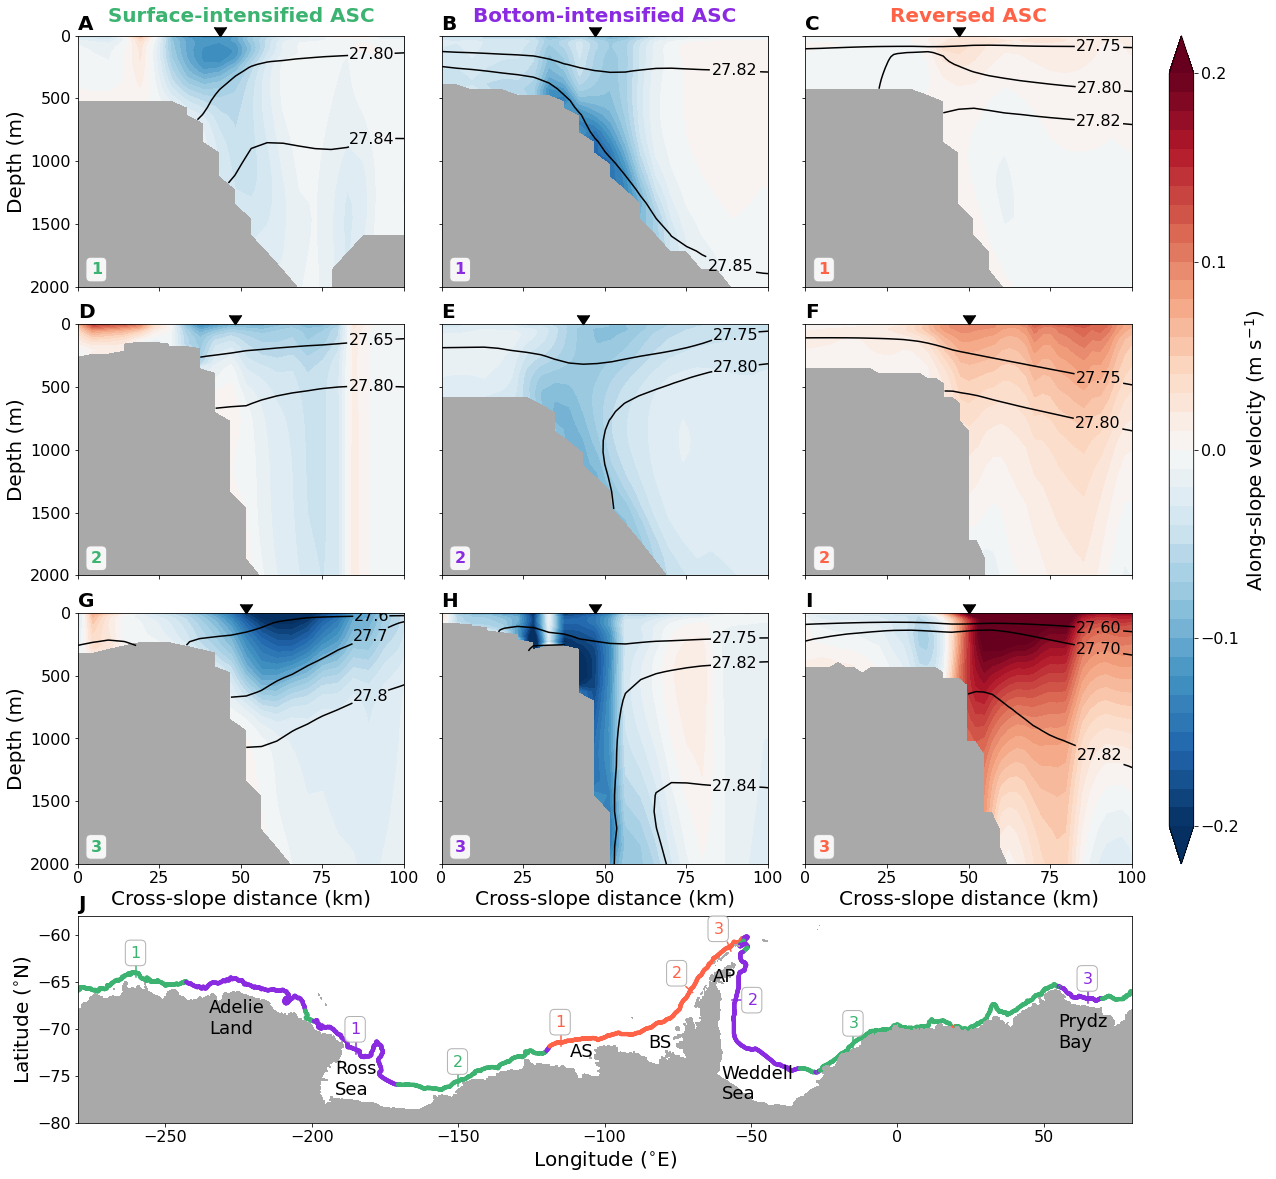

In [97]:
fig = plt.figure(figsize=(20,20))
gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 0.25], hspace=0.1)
gs1 = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs[0], height_ratios=[1, 1, 1], width_ratios=[1, 1, 1, 0.075], hspace=0.15, wspace=0.15)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], width_ratios=[1, 1, 1, 0.075], wspace=0.15)

regime_names = ['Surface-intensified ASC', 'Bottom-intensified ASC', 'Reversed ASC']
regime_clrs  = ['mediumseagreen', 'blueviolet', 'tomato']
levels_u   = np.arange(-0.2, 0.201, 0.01)
norm_u     = colors.Normalize(vmin=-0.2, vmax=0.2)
bbox_props = dict(boxstyle="round", fc="w", ec='darkgrey', alpha=0.9)

label_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

for ii in range(3):
    
    # Top row
    ax_u = fig.add_subplot(gs1[0,ii])
    if ii == 0:
        plt.ylabel('Depth (m)', fontsize=ft_size)
    else:
        ax_u.tick_params(labelleft=False)
    ax_u.tick_params(labelsize=ft_size-4, labelbottom=False)
    #plt.title(label_name[ii] + ' ' + regime_names[ii], fontsize=ft_size, loc='left', color=regime_clrs[ii], fontweight='bold')
    plt.title(regime_names[ii], fontsize=ft_size, loc='center', color=regime_clrs[ii], fontweight='bold', y=1.03)
    plt.title(label_name[ii], fontsize=ft_size, loc='left', color='k', fontweight='bold')
    if ii == 0:
        plt.fill_between(distance_surface_1, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_surface_1, u_surface_1.st_ocean, u_surface_1_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        #plt.fill_between(distance_surface_1, hu_surface_1, 2000, zorder=3, color='darkgrey')
        #CS = plt.contour(t_distance_surface_1, sigma1_surface_1.st_ocean, sigma1_surface_1, levels=[32.52, 32.56], colors='k')
        CS = plt.contour(t_distance_surface_1, sigma1_surface_1.st_ocean, sigma1_surface_1, levels=[27.8, 27.84], colors='k')
        manual_locations = [(90, 100), (90, 700)]
        tmp = int(index_1000m[ii])
        plt.scatter(distance_surface_1[tmp+1], 0, marker=7, color='k', s=150, clip_on = False)
    elif ii == 1:
        plt.fill_between(distance_bottom_1, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_bottom_1, u_bottom_1.st_ocean, u_bottom_1_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_bottom_1, sigma1_bottom_1.st_ocean, sigma1_bottom_1, levels=[27.82, 27.85], colors='k') # [32.53, 32.56]
        manual_locations = [(90, 100), (90, 1300)]
        tmp = int(index_1000m[ii+2])
        plt.scatter(distance_bottom_1[tmp+1], 0, marker=7, color='k', s=150, clip_on = False)
    elif ii == 2:
        plt.fill_between(distance_reversed_1, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_reversed_1, u_reversed_1.st_ocean, u_reversed_1_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_reversed_1, sigma1_reversed_1.st_ocean, sigma1_reversed_1, levels=[27.75, 27.8,27.82], colors='k') #[32.4, 32.5, 32.52]
        manual_locations = [(90, 100), (90, 600), (90, 900)]
        tmp = int(index_1000m[ii+4])
        plt.scatter(distance_reversed_1[tmp+1], 0, marker=7, color='k', s=150, clip_on = False)
    CL = plt.clabel(CS, fontsize=ft_size-4, inline_spacing=-3, manual=manual_locations)
    for l in CL:
        l.set_rotation(0)
    plt.ylim(2000, 0)
    plt.xlim(0, 100)
    plt.text(4, 1900, 1, fontsize=ft_size-4, fontweight='bold', color=regime_clrs[ii], bbox=bbox_props)
    plt.yticks(np.arange(0, 2250, 500))
    plt.xticks(np.arange(0, 125, 25))#(np.arange(0, 200, 50))
    
    # Middle row
    ax_t = fig.add_subplot(gs1[1,ii])
    if ii == 0:
        plt.ylabel('Depth (m)', fontsize=ft_size)
    else:
        ax_t.tick_params(labelleft=False)
    ax_t.tick_params(labelsize=ft_size-4, labelbottom=False)
    plt.title(label_name[ii+3], fontsize=ft_size, loc='left', color='k', fontweight='bold')
    if ii == 0:
        plt.fill_between(distance_surface_2, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_surface_2, u_surface_2.st_ocean, u_surface_2_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_surface_2, sigma1_surface_2.st_ocean, sigma1_surface_2, levels=[27.65, 27.8], colors='k') # [32.4, 32.5, 32.54]
        #manual_locations = [(90, 100), (90, 600), (90, 1600)]
        manual_locations = [(90, 100), (90, 600)]
        tmp = int(index_1000m[ii+1])
        plt.scatter(distance_surface_1[tmp+1], 0, marker=7, color='k', s=150, clip_on = False)
    elif ii == 1:
        plt.fill_between(distance_bottom_2, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_bottom_2, u_bottom_2.st_ocean, u_bottom_2_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_bottom_2, sigma1_bottom_2.st_ocean, sigma1_bottom_2, levels=[27.75, 27.8], colors='k') # [32.5, 32.54, 32.56]
        #manual_locations = [(90, 50), (90, 200), (90, 1300)]
        manual_locations = [(90, 50), (90, 200)]
        tmp = int(index_1000m[ii+3])
        plt.scatter(distance_bottom_2[tmp+1], 0, marker=7, color='k', s=150, clip_on = False)
    elif ii == 2:
        plt.fill_between(distance_reversed_2, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_reversed_2, u_reversed_2.st_ocean, u_reversed_2_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_reversed_2, sigma1_reversed_2.st_ocean, sigma1_reversed_2_masked, levels=[27.75, 27.8], colors='k') # [32.2, 32.4, 32.45, 32.5]
        #manual_locations = [(90, 50), (90, 400), (90, 600), (90, 1000)]
        manual_locations = [(90, 400), (90, 600)]
        #tmp = int(index_1000m[ii+5])
        plt.scatter(50, 0, marker=7, color='k', s=150, clip_on = False)
    CL = plt.clabel(CS, fontsize=ft_size-4, inline_spacing=-3, manual=manual_locations)
    for l in CL:
        l.set_rotation(0)
    plt.ylim(2000, 0)
    plt.xlim(0, 100)
    #plt.axvline(175, color='k')
    plt.text(4, 1900, 2, fontsize=ft_size-4, fontweight='bold', color=regime_clrs[ii], bbox=bbox_props)
    plt.yticks(np.arange(0, 2250, 500))
    plt.xticks(np.arange(0, 125, 25))#(np.arange(0, 200, 50))
    
    # Bottom row
    ax_t = fig.add_subplot(gs1[2,ii])
    if ii == 0:
        plt.ylabel('Depth (m)', fontsize=ft_size)
    else:
        ax_t.tick_params(labelleft=False)
    ax_t.tick_params(labelsize=ft_size-4)
    plt.title(label_name[ii+6], fontsize=ft_size, loc='left', color='k', fontweight='bold')
    plt.xlabel('Cross-slope distance (km)', fontsize=ft_size)
    if ii == 0:
        plt.fill_between(distance_surface_3, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_surface_3, u_surface_3.st_ocean, u_surface_3_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_surface_3, sigma1_surface_3.st_ocean, sigma1_surface_3, levels=[27.6, 27.7, 27.8], colors='k') # [32.4, 32.5, 32.54]
        manual_locations = [(90, 50), (90, 300), (90, 800)]
        tmp = int(index_1000m[ii+2])
        plt.scatter(distance_surface_3[tmp+1], 0, marker=7, color='k', s=150, clip_on = False)
    elif ii == 1:
        plt.fill_between(distance_bottom_3, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_bottom_3, u_bottom_3.st_ocean, u_bottom_3_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_bottom_3, sigma1_bottom_3.st_ocean, sigma1_bottom_3, levels=[27.75, 27.82, 27.84], colors='k') # [32.5, 32.56]
        #manual_locations = [(90, 200), (90, 1000)]
        manual_locations = [(90, 200), (90,400), (90, 1500)]
        tmp = int(index_1000m[ii+4])
        plt.scatter(distance_bottom_3[tmp+1], 0, marker=7, color='k', s=150, clip_on = False)
    elif ii == 2:
        plt.fill_between(distance_reversed_3, 0, 2000, color='darkgrey')
        SC = plt.contourf(distance_reversed_3, u_reversed_3.st_ocean, u_reversed_3_masked, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
        CS = plt.contour(t_distance_reversed_3, sigma1_reversed_3.st_ocean, sigma1_reversed_3_masked, levels=[27.6, 27.7, 27.82], colors='k')  # [32.4, 32.5, 32.52]
        #manual_locations = [(90, 250), (90, 800), (90, 1200)]
        manual_locations = [(90, 100), (90, 300), (90, 1200)]
        #tmp = int(index_1000m[ii+6])
        plt.scatter(50, 0, marker=7, color='k', s=150, clip_on = False)
    CL = plt.clabel(CS, fontsize=ft_size-4, inline_spacing=-3, manual=manual_locations)
    for l in CL:
        l.set_rotation(0)
    plt.ylim(2000, 0)
    plt.xlim(0, 100) # 175
    plt.text(4, 1900, 3, fontsize=ft_size-4, fontweight='bold', color=regime_clrs[ii], bbox=bbox_props)
    plt.yticks(np.arange(0, 2250, 500))
    plt.xticks(np.arange(0, 125, 25))#(np.arange(0, 200, 50))

# Map at bottom of plot
ax_map = fig.add_subplot(gs2[0,:-1])
sc = plt.scatter(lon_along_contour, lat_along_contour, c=ASC_regimes, cmap=CustomCmap_no3, s=10)
#for ii in range(9):
#    plt.plot(transect_lon_updated[ii], transect_lat_updated[ii], color='k')
plt.title(label_name[-1], fontsize=ft_size, loc='left', color='k', fontweight='bold')
for ii in range(len(transect_lon_updated)):
    # Colour of transect
    if regime[ii] == 0:
        clr_transect = 'mediumseagreen'
    elif regime[ii] == 1:
        clr_transect = 'blueviolet'
    elif regime[ii] == 2:
        clr_transect = 'tomato'
    # Plot transect
    plt.plot(transect_lon_updated[ii], transect_lat_updated[ii], color=clr_transect)
    # Plot transect number
    if ii not in (4,7,8):
        plt.text(transect_lon_updated[ii][1]-2, transect_lat_updated[ii][1]+0.9, '$\mathsf{'+str(count_regime[ii])+'}$', \
             fontsize=ft_size-4, color=clr_transect, bbox=bbox_props)
    elif ii in (7,8):
        plt.text(transect_lon_updated[ii][1]-5, transect_lat_updated[ii][1]+0.9, '$\mathsf{'+str(count_regime[ii])+'}$', \
             fontsize=ft_size-4, color=clr_transect, bbox=bbox_props)
    elif ii == 4:
        plt.text(transect_lon_updated[ii][1]+2, transect_lat_updated[ii][1]-0.5, '$\mathsf{'+str(count_regime[ii])+'}$', \
             fontsize=ft_size-4, color=clr_transect, bbox=bbox_props)

plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -58) 
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
plt.xticks( fontsize=ft_size-4)
plt.yticks(np.arange(-80, -59, 5), fontsize=ft_size-4);

# Add text to label regions
plt.text(-235, -70.5, 'Adelie\nLand', fontsize=ft_size-2, color='k')
plt.text(-192, -77.0, 'Ross\nSea', fontsize=ft_size-2, color='k')
plt.text(-112, -73, 'AS', fontsize=ft_size-2, color='k')
plt.text(-85, -72, 'BS', fontsize=ft_size-2, color='k')
plt.text(-63, -65, 'AP', fontsize=ft_size-2, color='k')
plt.text(-60, -77.5, 'Weddell\nSea', fontsize=ft_size-2, color='k')
plt.text(55, -72, 'Prydz\nBay', fontsize=ft_size-2, color='k');

# Colorbar axes
cbar_ax = fig.add_subplot(gs1[:, -1])
cbar = plt.colorbar(SC, cax=cbar_ax, ticks=np.arange(-0.2, 0.25, 0.1), extend='both')
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4);

# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_ASC_regimes_example_transects_sigma0.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

---

Plot below is version from initial submission. Daily data for year 2086.

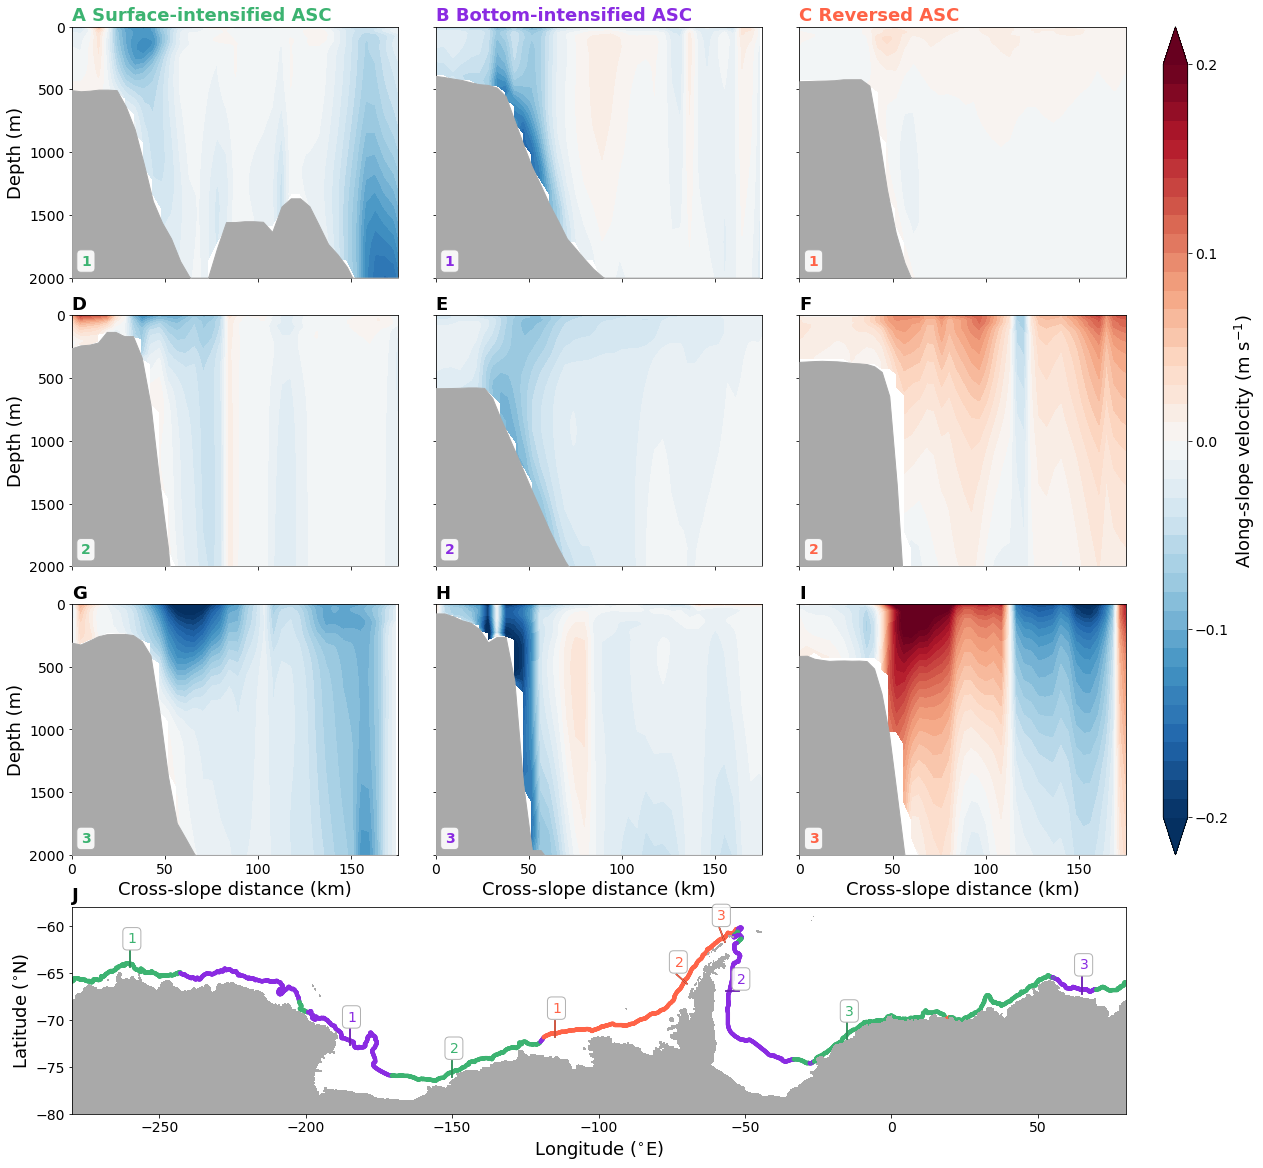

In [41]:
fig = plt.figure(figsize=(20,20))
gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 0.25], hspace=0.1)
gs1 = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs[0], height_ratios=[1, 1, 1], width_ratios=[1, 1, 1, 0.075], hspace=0.15, wspace=0.15)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], width_ratios=[1, 1, 1, 0.075], wspace=0.15)

regime_names = ['Surface-intensified ASC', 'Bottom-intensified ASC', 'Reversed ASC']
regime_clrs  = ['mediumseagreen', 'blueviolet', 'tomato']
levels_u   = np.arange(-0.2, 0.201, 0.01)
norm_u     = colors.Normalize(vmin=-0.2, vmax=0.2)
bbox_props = dict(boxstyle="round", fc="w", ec='darkgrey', alpha=0.9)

label_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

for ii in range(3):
    
    # Top row
    ax_u = fig.add_subplot(gs1[0,ii])
    if ii == 0:
        plt.ylabel('Depth (m)', fontsize=ft_size)
    else:
        ax_u.tick_params(labelleft=False)
    ax_u.tick_params(labelsize=ft_size-4, labelbottom=False)
    plt.title(label_name[ii] + ' ' + regime_names[ii], fontsize=ft_size, loc='left', color=regime_clrs[ii], fontweight='bold')
    u_tmp, hu_tmp, distance_tmp = get_transect_annual(ii*3)
    SC = plt.contourf(distance_tmp, u_tmp.st_ocean, u_tmp, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
    plt.fill_between(distance_tmp, hu_tmp, 2000, zorder=3, color='darkgrey')
    plt.ylim(2000, 0)
    plt.xlim(0, 175)
    #plt.axvline(175, color='k')
    plt.text(5, 1900, 1, fontsize=ft_size-4, fontweight='bold', color=regime_clrs[ii], bbox=bbox_props)
    plt.yticks(np.arange(0, 2250, 500))
    plt.xticks(np.arange(0, 200, 50))
    
    # Middle row
    ax_t = fig.add_subplot(gs1[1,ii])
    if ii == 0:
        plt.ylabel('Depth (m)', fontsize=ft_size)
    else:
        ax_t.tick_params(labelleft=False)
    ax_t.tick_params(labelsize=ft_size-4, labelbottom=False)
    plt.title(label_name[ii+3], fontsize=ft_size, loc='left', color='k', fontweight='bold')
    u_tmp, hu_tmp, distance_tmp = get_transect_annual((ii*3)+1)
    SC = plt.contourf(distance_tmp, u_tmp.st_ocean, u_tmp, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
    plt.fill_between(distance_tmp, hu_tmp, 2000, zorder=3, color='darkgrey')
    plt.ylim(2000, 0)
    plt.xlim(0, 175)
    #plt.axvline(175, color='k')
    plt.text(5, 1900, 2, fontsize=ft_size-4, fontweight='bold', color=regime_clrs[ii], bbox=bbox_props)
    plt.yticks(np.arange(0, 2250, 500))
    plt.xticks(np.arange(0, 200, 50))
    
    # Bottom row
    ax_t = fig.add_subplot(gs1[2,ii])
    if ii == 0:
        plt.ylabel('Depth (m)', fontsize=ft_size)
    else:
        ax_t.tick_params(labelleft=False)
    ax_t.tick_params(labelsize=ft_size-4)
    plt.title(label_name[ii+6], fontsize=ft_size, loc='left', color='k', fontweight='bold')
    plt.xlabel('Cross-slope distance (km)', fontsize=ft_size)
    u_tmp, hu_tmp, distance_tmp = get_transect_annual((ii*3)+2)
    SC = plt.contourf(distance_tmp, u_tmp.st_ocean, u_tmp, vmin=-0.2, vmax=0.2, cmap='RdBu_r', levels=levels_u, norm=norm_u, extend='both')
    plt.fill_between(distance_tmp, hu_tmp, 2000, zorder=3, color='darkgrey')
    plt.ylim(2000, 0)
    plt.xlim(0, 175)
    #plt.axvline(175, color='k')
    plt.text(5, 1900, 3, fontsize=ft_size-4, fontweight='bold', color=regime_clrs[ii], bbox=bbox_props)
    plt.yticks(np.arange(0, 2250, 500))
    plt.xticks(np.arange(0, 200, 50))

# Map at bottom of plot
ax_map = fig.add_subplot(gs2[0,:-1])
sc = plt.scatter(lon_along_contour, lat_along_contour, c=ASC_regimes, cmap=CustomCmap_no3, s=10)
for ii in range(9):
    plt.plot(transect_lon_updated[ii], transect_lat_updated[ii], color='k')
plt.title(label_name[-1], fontsize=ft_size, loc='left', color='k', fontweight='bold')
for ii in range(len(transect_lon_updated)):
    if regime[ii] == 0:
        clr_transect = 'mediumseagreen'
    elif regime[ii] == 1:
        clr_transect = 'blueviolet'
    elif regime[ii] == 2:
        clr_transect = 'tomato'
    plt.plot(transect_lon_updated[ii], transect_lat_updated[ii], color=clr_transect)
    plt.text(transect_lon_updated[ii][1]-1, transect_lat_updated[ii][1]+0.9, '$\mathsf{'+str(count_regime[ii])+'}$', \
             fontsize=ft_size-4, color=clr_transect, bbox=bbox_props)

plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-80, -58)  #(-82.5, -58)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
plt.xticks( fontsize=ft_size-4)
plt.yticks(np.arange(-80, -59, 5), fontsize=ft_size-4);


# Colorbar axes, covers both rows
cbar_ax = fig.add_subplot(gs1[:, -1])
cbar = plt.colorbar(SC, cax=cbar_ax, ticks=np.arange(-0.2, 0.25, 0.1), extend='both')
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4)
"""
cbar_ax = fig.add_subplot(gs1[1, -1])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(-2, 2.5, 1))
cbar.set_label('Temperature ($^{\circ}$C)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4)
"""
# Finished
save_fig = 0
if save_fig == 1:
    fig_name = 'Fig_ASC_regimes_transects_all.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')